# 그림생성 모델 예시
### (1) Pix2Pix
* 실제 이미지(ground truth)와 이미지(input image)을 쌍으로 학습함

### (2) CycleGAN
* 양방향 이미지로 변환이 가능 : 실사 <-> 그림
* 쌍으로 이루어진 데이터가 필요없음 : 이미지에서 각각의 스타일을 학습해서 다음 이미지에 입힘

### (3) Neural Style Transfer
* Base image 에서 content 와 style 을 분리하여 전달함

# GAN
## (1) 데이터셋 구성하기
### Fasion MNIST
* 60000 개의 훈련셋
* 그레이스케일의 28x28 이미지, 10 개 클래스

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
train_x = (train_x - 127.5) / 127.5   # [-1,1] 범위로 정규화

In [5]:
train_x.shape

(60000, 28, 28)

In [6]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

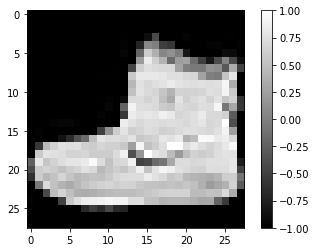

In [7]:
plt.imshow(train_x[0].reshape(28,28), cmap='gray')
plt.colorbar()
plt.show()

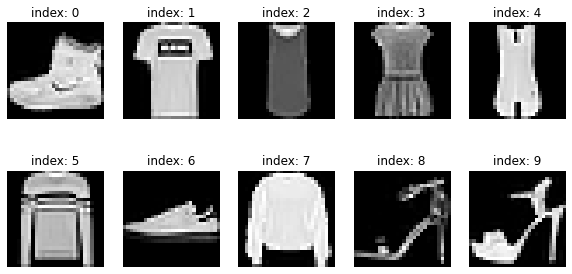

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28,28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

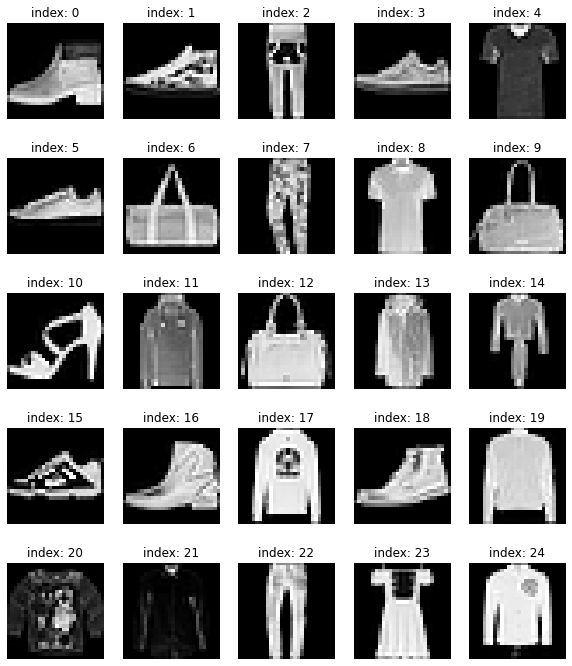

In [14]:
plt.figure(figsize=(10,12))

for i in range(25):
    idx = np.random.randint(1, train_x.shape[0])
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[idx].reshape(28,28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

### 미니배치 학습

In [17]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## GAN
* 생성자 Generator : 아무 의미 없는 랜덤 노이즈로부터 신경망을 거쳐 이미지와 닮은 벡터를 생성함
* 판별자 Discriminator : 기존에 있던 이미지와 생성된 이미지를 비교하여 진위 여부를 실숫값으로 출력함

## (2) 생성자 구현하기
```DCGAN Deep Convolutional GAN```

Tensorflow 2.0 tutorial DCGAN 구현 참고

In [28]:
def make_generator_model():
    
    model = tf.keras.Sequential()
    
    # Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Reshape layer
    model.add(layers.Reshape((7,7,256)))
    
    # Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5,5),
                                    strides=(1,1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Conv2DTrnaspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5,5),
                                    strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5,5),
                                    strides=(2,2), padding='same',
                                    use_bias=False, activation='tanh'))
    return model

```Conv2DTranspose```층을 이용해 이미지의 사이즈를 넓혀줌
```(7,7,256) -> (14,14,64) -> (28,28,1)```
최종 이미지의 크기를 데이터셋 형상과 동일하게 맞춤

In [25]:
generator = make_generator_model()

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_4 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)        

In [22]:
noise = tf.random.normal([1,100])

In [26]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

* 통로만 만들었을 뿐, 학습이 전혀 진행되지 않았기 때문에 28x28 크기의 노이즈만 출력됨

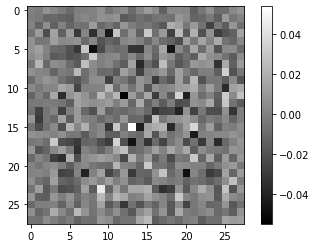

In [27]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

## (3) 판별자 구현하기
입력으로 들어온 이미지 별로 '진짜라고 판단하는 정도'를 값으로 출력

In [29]:
def make_discriminator_model():
    
    model = tf.keras.Sequential()
    
    # Conv2D layer
    model.add(layers.Conv2D(64, (5,5), 
                            strides=(2,2), padding='same',
                           input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Conv2D layer
    model.add(layers.Conv2D(128, (5,5), 
                            strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten layers
    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(1))
    
    return model

In [32]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

In [33]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00018668]], dtype=float32)>

## (4) 손실함수와 최적화 함수
* 이진 교차 엔트로피 Binary Cross Entropy : Real(1), Fake(0)
* 생성자 : D(fake_image) 값이 1 에 가까워 지는 것이 목표
* 판별자 : D(real_image) 값은 1 에, D(fake_image) 값은 0에 가까워 지는 것

In [34]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [35]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Discriminator accuracy
Real accuracy 와 fake accuracy 가 초반 1.0 에 가깝게 나오다가, 서서히 0.5 에 가까워지는 것이 이상적임

In [36]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### Optimizer
Learning rate = 0.0001 로 설정

생성자, 구분자 따로 학습을 진행하기 때문에 optimizer도 개별 생성

In [37]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [38]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 훈련과정 설계
Tenserflow 2.0 이상 부터 session.run 대신 작동 함수에 데코레이터 설정
```
@tf.function
def func():
    return
```

In [40]:
# import numpy as np
# import tensorflow as tf

# @tf.function
# def f(x,y):
#     print(type(x))
#     print(type(y))
#     return x ** 2 + y

# x = np.array([2, 3])
# y = np.array([3, -2])
# f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

In [42]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값